In [46]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

In [32]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [33]:
ix_train, ix_test = list(ShuffleSplit(X.shape[0], n_iter=1, test_size=.3, random_state=0))[0]

In [34]:
X_train, X_test, y_train, y_test = X[ix_train, :], X[ix_test, :], y[ix_train], y[ix_test]

In [35]:
std = StandardScaler()
std.fit(X_train)

X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [36]:
ppn = Perceptron(n_iter=40, eta0=.1, random_state=0)

ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=40, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [39]:
y_pred = ppn.predict(X_test_std)

In [64]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94        16
          1       0.94      0.83      0.88        18
          2       0.91      0.91      0.91        11

avg / total       0.91      0.91      0.91        45



In [65]:
print(accuracy_score(y_test, y_pred))

0.911111111111


In [31]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=.2, ax=None):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('r', 'b', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    
    if not ax:
        
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
    
    ax.contourf(xx1, xx2, z, alpha=.4, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    if test_idx is not None:
        
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0], X_test[:, 1], c='',\
                    alpha=1., linewidths=1, marker='o',\
                    s=55, label='test set')

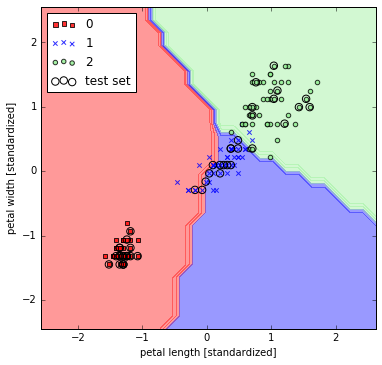

In [37]:
X_std = np.vstack((X_train_std, X_test_std))
y_std = np.hstack((y_train, y_test))

plt.figure(figsize=(14, 14))

plot_decision_regions(X_std, y_std, ppn, test_idx=ix_test)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

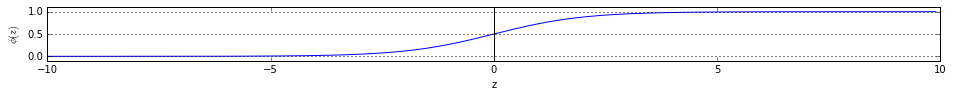

In [28]:
sigmoid = lambda z: 1. / (1. + np.exp(-z))
z = np.arange(-10, 10, .1)
phi_z = sigmoid(z)

plt.figure(figsize=(16, 8))
plt.plot(z, phi_z)
plt.axvline(.0, color='k') # vertical line
plt.axhline(.0, ls='dotted', color='k') # horizontal line
plt.axhline(.5, ls='dotted', color='k') # horizontal line
plt.axhline(1., ls='dotted', color='k') # horizontal line
plt.yticks([.0, .5, 1.])
plt.ylim(-.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.gca().set_aspect('equal')

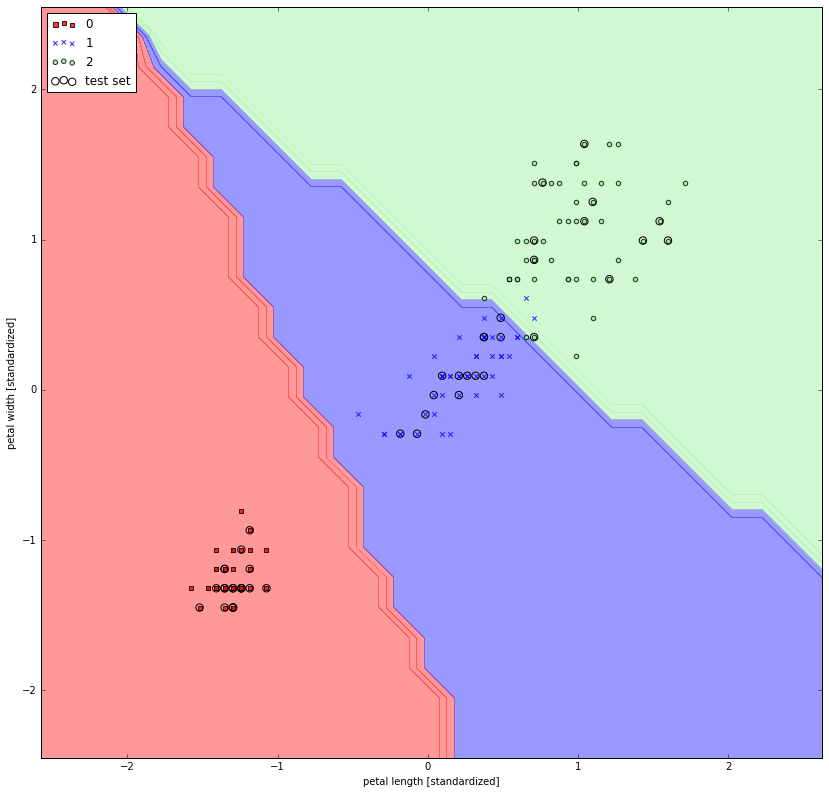

In [42]:
plt.figure(figsize=(14, 14))

plot_decision_regions(X_std, y_std, lr, test_idx=ix_test)
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

In [46]:
lr.predict_proba(X_test_std[0, :].reshape(1, 2))

array([[  2.05743774e-11,   6.31620264e-02,   9.36837974e-01]])

### Regularization

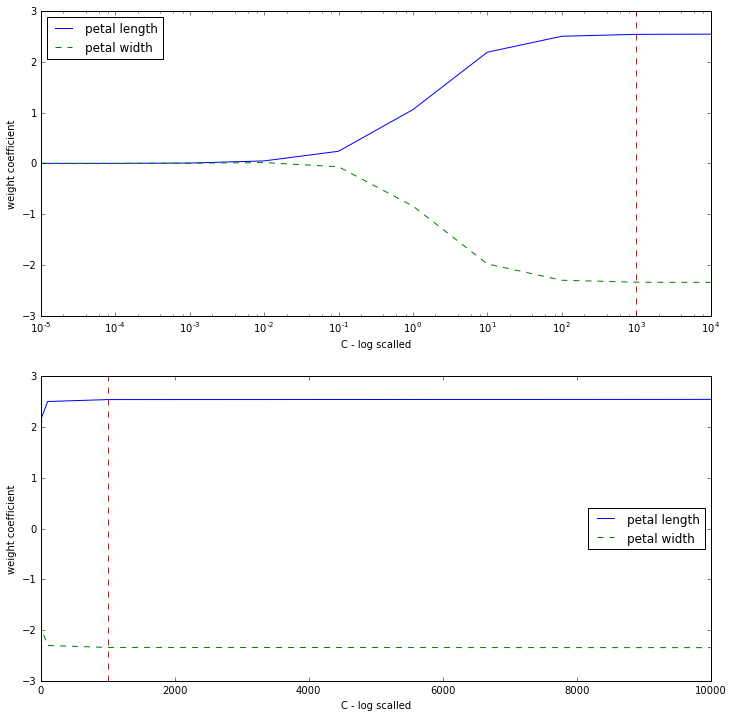

In [81]:
weights, params = [], []

for C in 10.**np.arange(-5, 5):

    lr = LogisticRegression(C=C, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1]) # coefs da classe 1, em esquema One Vs All
    params.append(C)
    
weights = np.array(weights)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(params, weights[:, 0], label='petal length')
ax1.plot(params, weights[:, 1], label='petal width', linestyle='--')
ax1.set_ylabel('weight coefficient')
ax1.set_xlabel('C - log scalled')
ax1.legend(loc='upper left')
ax1.set_xscale('log')

# como interpretar esses gráficos com eixos em escalas não lineares?!
ax1.axvline(1000., linestyle='--', color='r')

ax2.plot(params, weights[:, 0], label='petal length')
ax2.plot(params, weights[:, 1], label='petal width', linestyle='--')
ax2.set_ylabel('weight coefficient')
ax2.set_xlabel('C - log scalled')
ax2.legend(loc='center right')
ax2.axvline(1000., linestyle='--', color='r')

## Maximum margin classification with support vector machines

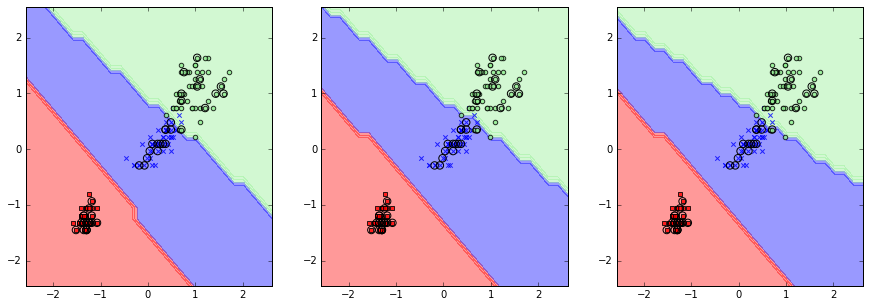

In [48]:
svm1 = SVC(kernel='linear', C=1., random_state=0).fit(X_train_std, y_train)
svm2 = SVC(kernel='linear', C=10., random_state=0).fit(X_train_std, y_train)
svm3 = SVC(kernel='linear', C=10000., random_state=0).fit(X_train_std, y_train)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

plot_decision_regions(X_std, y_std, svm1, test_idx=ix_test, ax=ax1)
plot_decision_regions(X_std, y_std, svm2, test_idx=ix_test, ax=ax2)
plot_decision_regions(X_std, y_std, svm3, test_idx=ix_test, ax=ax3)

In [34]:
len(X_std[ix_test].shape)

2

## Solving nonlinear problems using a kernel SVM

In [49]:
np.random.seed(0)

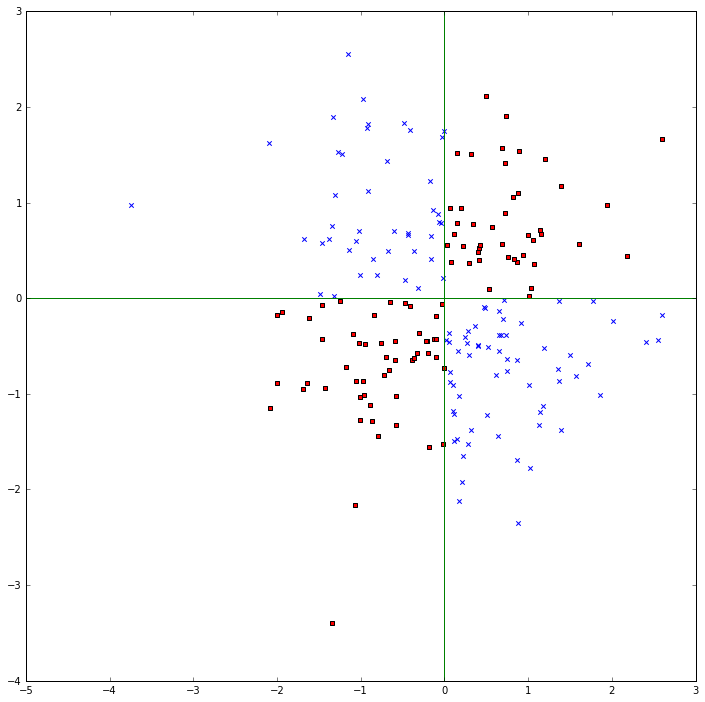

In [59]:
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.figure(figsize=(12, 12))
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1')
plt.axhline(.0, color='g')
plt.axvline(.0, color='g')

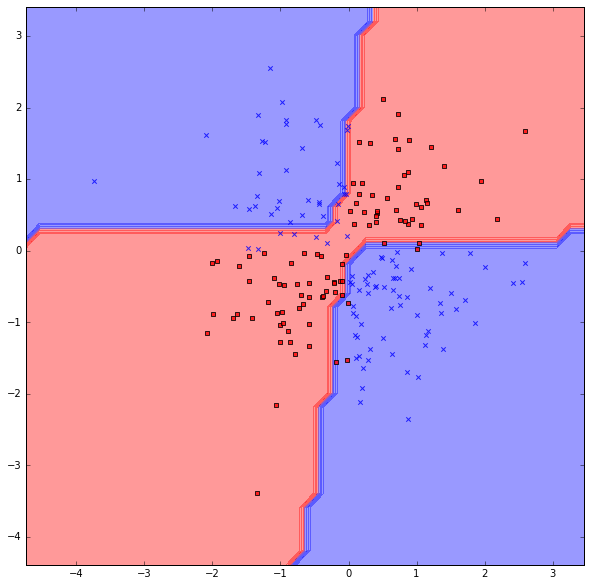

In [166]:
svm = SVC(kernel='rbf', random_state=0, gamma=.1, C=1.).fit(X_xor, y_xor)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_decision_regions(X_xor, y_xor, svm, ax=ax)

In [73]:
X_xor_on_roids = np.c_[X_xor, X_xor[:, 0] * X_xor[:, 1]]

In [157]:
def plot_decision_regions_on_roids(X, y, classifier, test_idx=None, resolution=.2, ax=None):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('r', 'b', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    xx3 = xx1 * xx2
    
    xx = np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()])
    
    z = classifier.predict(xx.T)
    z = z.reshape(xx1.shape)
    
    if not ax:
        
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
    
    ax.contourf(xx1, xx2, z, alpha=.4, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    if test_idx is not None:
        
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0], X_test[:, 1], c='',\
                    alpha=1., linewidths=1, marker='o',\
                    s=55, label='test set')

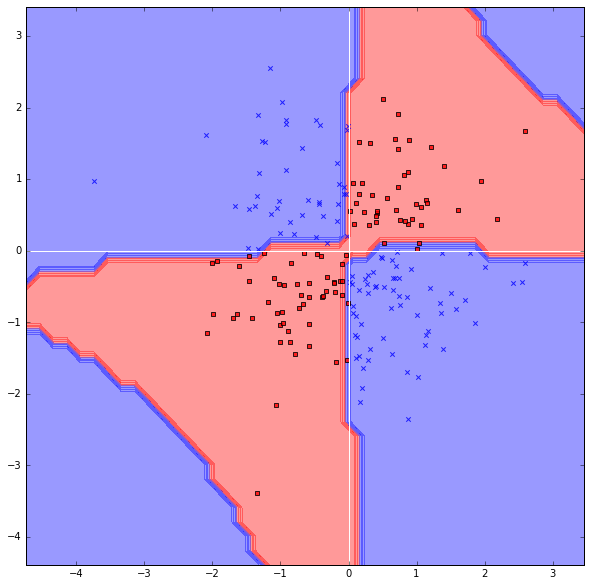

In [158]:
svm = SVC(kernel='rbf', random_state=0, gamma=.1, C=100.).fit(X_xor_on_roids, y_xor)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_decision_regions_on_roids(X_xor, y_xor, svm, ax=ax)
ax.axvline(.0, color='w')
ax.axhline(.0, color='w')

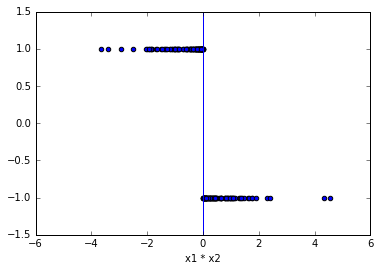

In [162]:
plt.scatter(X_xor[:, 0]*X_xor[:, 1], y_xor)
plt.xlabel("x1 * x2")
plt.axvline(.0)

## Decision tree learnign

In [25]:
gini = lambda p: 2 * p * (1 - p)
entropy = lambda p: -1 * p * np.log2(p) - (1 - p) * np.log2(1 - p)
error = lambda p: 1 - np.max(np.c_[p, 1 - p], axis=1)

x = np.arange(.0, 1., .01)

ent = entropy(x)
sc_ent = ent * .5
err = error(x)
gin = gini(x)

/home/abevieiramota/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/abevieiramota/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


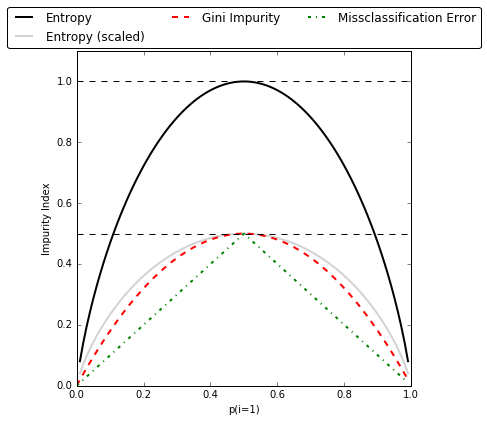

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(x, ent, label='Entropy', linestyle='-', lw=2, color='black')
ax.plot(x, sc_ent, label='Entropy (scaled)', linestyle='-', lw=2, color='lightgray')
ax.plot(x, gin, label='Gini Impurity', linestyle='--', lw=2, color='red')
ax.plot(x, err, label='Missclassification Error', linestyle='-.', lw=2, color='green')

ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.15), ncol=3, fancybox=True, shadow=False)

ax.axhline(.5, linewidth=1, color='k', linestyle='--')
ax.axhline(1., linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

### Building a decision tree

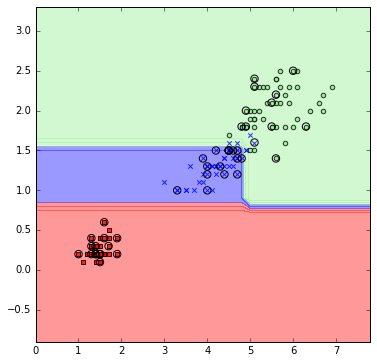

In [40]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0).fit(X_train, y_train)

plot_decision_regions(X, y, tree, test_idx=ix_test)

### Combining weak to strong learners via random forests

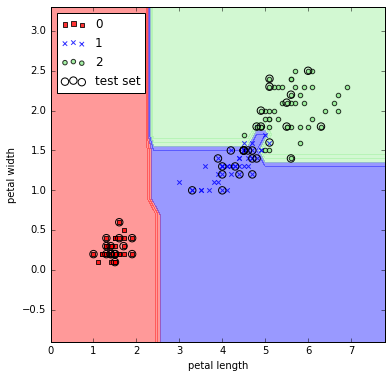

In [45]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2).fit(X_train, y_train)

plot_decision_regions(X, y, forest, test_idx=ix_test)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')

## K-nearest neighbors - a lazy learning algorithm

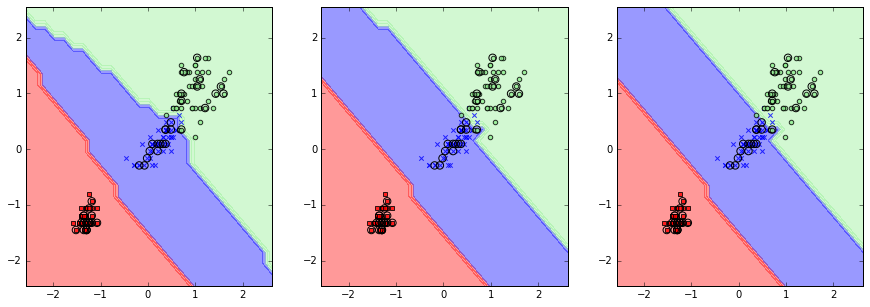

In [55]:
knn2 = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski').fit(X_train_std, y_train)
knn10 = KNeighborsClassifier(n_neighbors=5, p=10, metric='minkowski').fit(X_train_std, y_train)
knn20 = KNeighborsClassifier(n_neighbors=5, p=20, metric='minkowski').fit(X_train_std, y_train)

fig, (ax2, ax10, ax20) = plt.subplots(1, 3, figsize=(15, 5))

plot_decision_regions(X_std, y_std, knn2, test_idx=ix_test, ax=ax2)
plot_decision_regions(X_std, y_std, knn10, test_idx=ix_test, ax=ax10)
plot_decision_regions(X_std, y_std, knn20, test_idx=ix_test, ax=ax20)